In [3]:
# ! pip install git+https://github.com/JiakaiW/CoupledQuantumSystems       

In [1]:
from scipy.optimize import curve_fit
import scipy
from scipy.special import erfc
from skimage.transform import radon
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall
from CoupledQuantumSystems.mcsolve_utils import pack_mcsolve_chunks, pack_pkl_files_to_zip, merge_results
import matplotlib.pyplot as plt
import qutip
import pickle

In [2]:
max_ql = 20
max_ol = 300
EJ = 3
EC = EJ/6
EL = EJ/25
Er =  6.8

g = 0.2
w_d = 6.798176579812265
amp = 0.015
kappa = 0.003

tot_time =400
tlist = np.linspace(0, tot_time, tot_time)

with open('ef_mcsolve_system_g0.2.pkl', 'rb') as f:
    system = pickle.load(f)

# 2 store the mcsolve jobs

In [3]:
state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

leakage_products_to_keep = [[ql, ol] for ql in [0] for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in [1,2] for ol in range(100) ]
list_of_products_to_keep = [
    leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]

# ntraj_per_y0 = 1000
# chunk_size = 4
# existing_chunk_num = 0
# for y0, products_to_keep in zip(initial_states, list_of_products_to_keep):
#     system.set_new_product_to_keep(products_to_keep)
#     system.set_new_operators_after_setting_new_product_to_keep()
#     existing_chunk_num = pack_mcsolve_chunks(
#                     y0 = system.truncate_function(y0),
#                     tlist = tlist,
#                     static_hamiltonian = system.diag_dressed_hamiltonian,
#                     drive_terms = [DriveTerm( 
#                                 driven_op= system.driven_operator,
#                                 pulse_shape_func=square_pulse_with_rise_fall,
#                                 pulse_shape_args={
#                                     'w_d': w_d ,
#                                     'amp': amp,
#                                     't_rise': 20,
#                                     't_square': tot_time
#                                 })],                    
#                     c_ops = system.c_ops,
#                     e_ops = [system.a_trunc , system.a_trunc.dag()*system.a_trunc],
#                     ntraj = ntraj_per_y0,
#                     existing_chunk_num = existing_chunk_num,
#                     chunk_size = chunk_size)
    
# pack_pkl_files_to_zip(zip_filename="mcsolve_input_g02a015kappa003.zip")

# print(existing_chunk_num)

# 3 sent to condor and run


# 4 load the mcsolve results, average them

In [5]:
# zip_files = [f"zipped_results_g2a015k003/result_{i}.zip" for i in range(int(ntraj_per_y0*len(initial_states)/chunk_size))]
# n_parts = len(initial_states)
# part_length = len(zip_files) // n_parts
# zip_file_parts = [zip_files[i * part_length : (i + 1) * part_length] for i in range(n_parts)]

# results = []
# for part in zip_file_parts:
#     results.append(merge_results(part))

# with open('averaged_g2a015k003.pkl', 'wb') as f:
#     pickle.dump(results,f)

progress: 100%|██████████| 250/250 [01:33<00:00,  2.68it/s]


In [11]:
with open('averaged_g2a015k003.pkl', 'rb') as f:
    results = pickle.load(f)

In [17]:
from functools import partial
import multiprocessing
from tqdm import tqdm

def convert_dressed_to_product_vectorized(system, states, products_to_keep, num_processes=None, update_products_to_keep=True):
    if update_products_to_keep:
        system.set_new_product_to_keep(products_to_keep)
        system.set_new_operators_after_setting_new_product_to_keep()

    if num_processes is None:
        num_processes = multiprocessing.cpu_count()

    # Multiprocessing, vectorized
    partial_function = partial(get_product_vectorized,
                               pad_back_custom=system.pad_back_function,
                               product_to_dressed=system.product_to_dressed,
                               sign_multiplier_vector=system.sign_multiplier_vector)

    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the iterator to show the progress
        product_states = list(tqdm(pool.imap(partial_function, states), total=len(states), desc="Processing States"))

    return product_states


In [18]:
for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
    result.states_in_product_basis = convert_dressed_to_product_vectorized(system=system, 
                                                                           states= result.states,
                                                                            products_to_keep = products_to_keep,
                                                                            num_processes = 14
                                                                                    )
with open('mcsolve_results_with_product_basis_g2a015k003.pkl', 'wb') as f:
    pickle.dump(results,f)

Processing States: 100%|██████████| 400/400 [03:18<00:00,  2.02it/s]


In [4]:
with open('mcsolve_results_with_product_basis_g2a015k003.pkl', 'rb') as f:
    results = pickle.load(f)

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cbook.py: 1345

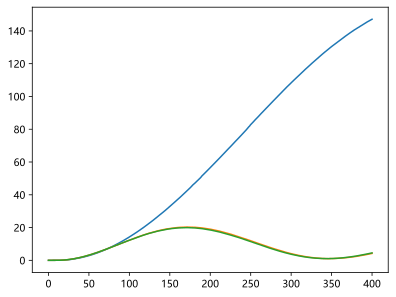

In [5]:
for i in [0,1,2]:
    plt.plot(tlist,results[i].expect[1])

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cbook.py: 1345

(1.0, 1.3)

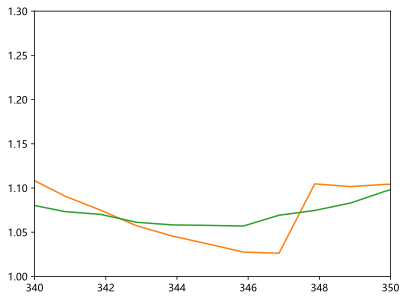

In [6]:
for i in [0,1,2]:
    plt.plot(tlist,results[i].expect[1])
plt.xlim(340,350)
plt.ylim(1,1.3)

In [7]:
last_t_idx=346
tlist[last_t_idx]

346.8671679197995

In [8]:
prefix = rf'$\kappa = 2\times 10^{{-3}}$'
frequency_used = -1*w_d

Text(0.5, 0, 't (ns)')

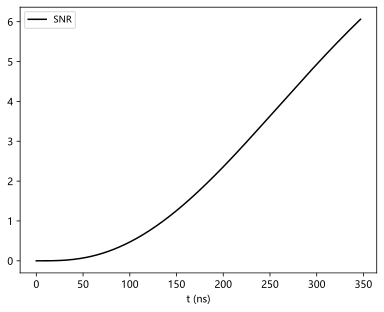

In [9]:
efficiency = 1
kappa_used = kappa
alpha_arr_0 = np.sqrt(kappa_used)*(results[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)  )[:last_t_idx+1] 
alpha_arr_1 = np.sqrt(kappa_used)*(results[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1] 
diff_arr = np.abs(alpha_arr_0-alpha_arr_1)
numerator = np.sqrt(kappa_used * efficiency) * scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0)
denominator =np.sqrt(kappa_used *  tlist[:last_t_idx+1] / 2 * 2)
denominator[0]+= 1e-10 # avoid dividing by zero
SNR = numerator / denominator
plt.plot(tlist[:last_t_idx+1],SNR,color='black',label='SNR')
plt.legend(loc = 'upper left',prop={'size': 9})
plt.xlabel(rf't (ns)')

# 6 get the frequency to apply rotation to coherent state

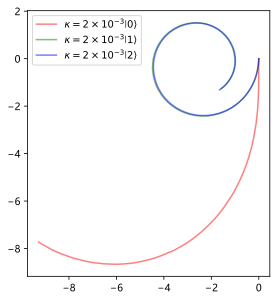

In [10]:
colors = ['red','green','blue']
for ql, result in zip([0,1,2],results[:3]):
    alpha = result.expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)
    plt.plot(alpha.real,alpha.imag,color=colors[ql],label = prefix + rf'$\left|{ql}\right>$',alpha=0.5)


# frequency_used = -0.0729
# colors = ['red','blue','green']
# for i, result in enumerate(results[:3]):
#     alpha = result.expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)
#     plt.plot(alpha.real,alpha.imag,color=colors[i],label = prefix + rf'$\left|{i}\right>$')
plt.legend()
plt.gca().set_aspect('equal', 'box')

In [10]:
lim = 25
xvec = np.linspace(-1*lim,lim,500)
X, Y = np.meshgrid(xvec, xvec)

In [11]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

QFunc_instance =  qutip.QFunc(xvec, xvec,2,memory=4096)

def get_q_value(ql,t_idx):
    rho_product = results[ql].states_in_product_basis[t_idx]
    rho = qutip.Qobj(np.array(rho_product.ptrace(1)))
    # U_inv = ( -1j  *  frequency_used * 2*np.pi * qutip.create(max_ol) * qutip.destroy(max_ol) * tlist[t_idx] ).expm().dag()  # Inverse rotation operator

    U_inv = ( 1j  *  frequency_used * 2*np.pi * qutip.create(max_ol) * qutip.destroy(max_ol) * tlist[t_idx] ).expm().dag()  # Inverse rotation operator
    rho = U_inv * rho * U_inv.dag()

    rho = rho/rho.tr()
    rho = (rho + rho.dag()) / 2

    q_values = QFunc_instance(rho)
    return q_values

def plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.5,0.99, 0.999]):
    sorted_q = np.sort(q_values.ravel())
    cumulative_sum = np.cumsum(sorted_q)
    total_sum = cumulative_sum[-1]
    for prob in levels:
        level_value = sorted_q[np.argmax(cumulative_sum >= total_sum * (1 - prob))]
        # fmt = {level_value:f'{1 - prob:.2f}'}   
        if type(ax) == list:
            for each_ax in ax:
                contour = each_ax.contour(X, Y, q_values, levels=[level_value], colors=[(prob, 0, 0, 1)])
                # each_ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 
        else:
            contour = ax.contour(X, Y, q_values, levels=[level_value], colors='black',alpha=0.5)
            # ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 


KeyboardInterrupt: 

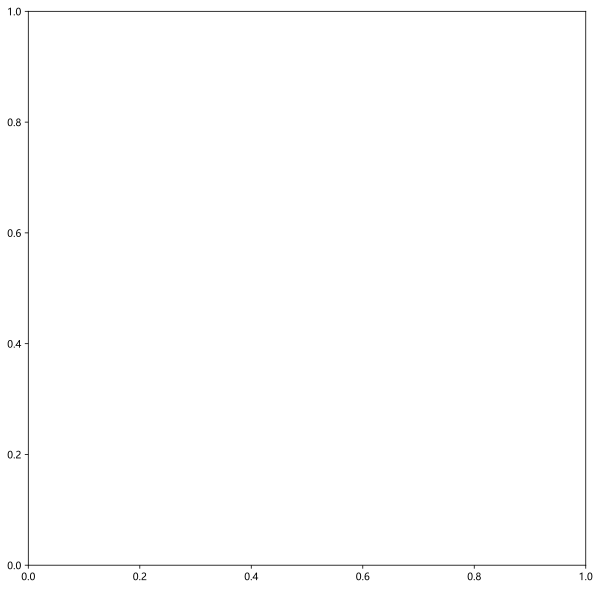

In [29]:
fig,ax = plt.subplots(figsize = (10,10))
for t_idx in [346]:
    for ql in [0,1]:
        q_values = get_q_value(ql,t_idx)
        plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.01,0.5,0.99])
    print(f"done one")

for i, result in enumerate(results[:3]):
    alpha = result.expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)
    ax.plot(alpha.real,alpha.imag,color=colors[i],alpha=0.5)

ax.set_xlim(-1*lim,lim)
ax.set_ylim(-1*lim,lim)

In [12]:
def gaussian(xvec, A, mu, sigma):
    return A * np.exp(-0.5 * ((xvec - mu) / sigma)**2)

def fit_gaussian(y,xvec,print_fit = False):
    popt, pcov = curve_fit(gaussian, xvec, y, p0=[np.max(y), xvec[np.argmax(y)], 1]) 
    for i in range(len(pcov)):
        if pcov[i][i] >= 1e-1:
            raise Exception(f'covariance too large: {pcov[i][i]}')     
    A, mu, sigma =  popt
    return A, mu, sigma


def get_fit_accuracy(y,xvec, A, mu, sigma):
    y_fit = gaussian(xvec, A, mu, sigma)
    RSS = np.sum((y_fit - y_fit)**2) #Residual Sum of Squares 
    TSS = np.sum((y - np.mean(y))**2)
    R_squared = 1 - (RSS / TSS) # how much of the variance is explained by the model
    RMSE = np.sqrt(np.mean((y - y_fit)**2)) #  Root Mean Square Error
    # print("RSS:", RSS)
    # print("R-squared (R²) value:", R_squared)
    # print("RMSE:", RMSE)
    return RSS, R_squared, RMSE

from scipy.stats import norm
def calculate_overlap(q_values_leak,q_values_compu,theta):
    y_leak = radon(q_values_leak,theta=theta).flatten()
    y_compu = radon(q_values_compu,theta=theta).flatten()

    A_leak, mu_leak, sigma_leak = fit_gaussian(y_leak,xvec=xvec)
    A_compu, mu_compu, sigma_compu = fit_gaussian(y_compu,xvec=xvec)

    # Compute the probability density functions (PDFs) of the two Gaussian distributions
    min_mean = min(mu_leak - 4 * sigma_leak, mu_compu - 4 * sigma_compu)
    max_mean = max(mu_leak + 4 * sigma_leak, mu_compu + 4 * sigma_compu)
    x_values = np.linspace(min_mean, max_mean, 1000)
    pdf1 = norm.pdf(x_values, mu_leak, sigma_leak) * A_leak
    pdf2 = norm.pdf(x_values, mu_compu, sigma_compu) * A_compu
    overlap_area = np.trapz(np.minimum(pdf1, pdf2), x_values)
    return overlap_area

from scipy.optimize import minimize
def optimize_theta(q_values_leak,q_values_compu,guess=-10.0):
    def objective(params):
        return calculate_overlap(q_values_leak,q_values_compu,params)
    initial_guess = np.array([guess])
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x[0]


In [31]:
last_t_idx = 346
t_indices = [0, 70, 140, 210, 280, 346]

In [32]:
def get_t_slice_husimi_data(t_idx):
    q_values_leak = get_q_value(ql = 0 , t_idx =t_idx)
    q_values_compu0 = get_q_value(ql = 1 , t_idx =t_idx)
    q_values_compu1 = get_q_value(ql = 2 , t_idx =t_idx)

    theta = optimize_theta(q_values_leak,q_values_compu0)
    
    theta = np.array([theta])
    y_leak = radon(q_values_leak,theta=theta).flatten()
    y_compu0 = radon(q_values_compu0,theta=theta).flatten()
    y_compu1 = radon(q_values_compu1,theta=theta).flatten()

    return q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1


husimi_plotting_results = []
for t_idx in t_indices:
    result = get_t_slice_husimi_data(t_idx)
    husimi_plotting_results.append(result)
    print('done one')
with open('husimi_data_time_slices_5step_g2a015k003.pkl', 'wb') as f:
    pickle.dump(husimi_plotting_results, f)

# with open('husimi_data_time_slices_5step_g2a015k003.pkl', 'rb') as f:
#     husimi_plotting_results = pickle.load(f)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/skimage/transform/radon_transform.py: 74

done one
done one
done one
done one
done one
done one


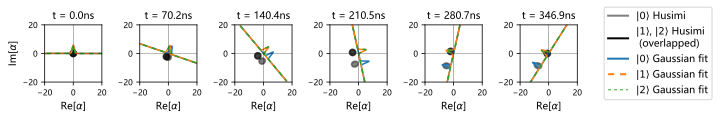

In [33]:
fig, axes = plt.subplots(1, 7, figsize=(10, 1.6),width_ratios=[3,3,3,3,3,3,4.5])

plt.subplots_adjust(wspace=0.05)

for col, (t_idx, ax, result) in enumerate(zip(t_indices, axes[:-1],husimi_plotting_results)):  # Only take first 6 axes
    q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result

    theta = -theta[0]/180*np.pi
    if col == 0:
        theta = 0

    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    new_x_leak, new_y_leak =  np.dot(rotation_matrix,np.array([xvec, y_leak]))
    new_x_compu0, new_y_compu0 =  np.dot(rotation_matrix,np.array([xvec, y_compu0]))
    new_x_compu1, new_y_compu1 =  np.dot(rotation_matrix,np.array([xvec, y_compu1]))


    plot_qfunc_cdf_contours(ax, q_values_leak,levels = [0.3,0.9,0.99])
    plot_qfunc_cdf_contours(ax, q_values_compu0,levels = [0.3,0.9,0.99])
    plot_qfunc_cdf_contours(ax, q_values_compu1,levels = [0.3,0.9,0.99])

    ax.plot(new_x_leak, new_y_leak,color=colors[0],alpha=1)
    ax.plot(new_x_compu0, new_y_compu0,color=colors[1],alpha=1)
    ax.plot(new_x_compu1, new_y_compu1,color=colors[2],alpha=1,linestyle=(0,(3,3)))
    ax.set_aspect('equal', 'box')


    lim = 20
    ax.set_xlim(-1*lim,lim)
    ax.set_ylim(-1*lim,lim)
    ax.set_aspect('equal')
    ax.set_title(f"t = {tlist[t_idx]:.1f}ns", fontdict={'fontsize': 10})
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.axhline(y=0, color='black',lw=0.3)
    ax.axvline(x=0, color='black',lw=0.3)
    ax.set_xlabel(rf'Re[$\alpha$]')
axes[0].set_ylabel(rf'Im[$\alpha$]')
axes[-1].axis('off')

# Add the legend to the last column
legend_lines = [
    plt.Line2D([0], [0], color='black', alpha=0.5,lw=2, label=r'$|0\rangle$ Husimi'),
    plt.Line2D([0], [0], color='black', lw=2,  label=r'$|1\rangle$, $|2\rangle$ Husimi'+'\n (overlapped)'),

    plt.Line2D([0], [0], color=colors[0], lw=2, label=r'$|0\rangle$ Gaussian fit'),
    plt.Line2D([0], [0], color=colors[1], lw=2, linestyle=(0, (3, 3)), label=r'$|1\rangle$ Gaussian fit'),
    plt.Line2D([0], [0], color=colors[2], lw=1, linestyle=(0, (3, 3)), label=r'$|2\rangle$ Gaussian fit')
]
axes[-1].legend(handles=legend_lines, loc='center')
plt.tight_layout()
fig.savefig('husimi_g2a015k003.pdf')

In [13]:

import multiprocessing as mp
from tqdm import tqdm

def calculate_SNR_single(t_idx):
    # This function processes a single t_idx
    q_values_leak = get_q_value(ql=1, t_idx=t_idx)
    q_values_compu = get_q_value(ql=0, t_idx=t_idx)
    
    theta = optimize_theta(q_values_leak, q_values_compu)
    theta = np.array([theta])
    
    y_leak = radon(q_values_leak, theta=theta).flatten()
    y_compu = radon(q_values_compu, theta=theta).flatten()

    A_leak, mu_leak, sigma_leak = fit_gaussian(y_leak, xvec=xvec)
    A_compu, mu_compu, sigma_compu = fit_gaussian(y_compu, xvec=xvec)

    leak_accuracy = get_fit_accuracy(y_leak, xvec, A_leak, mu_leak, sigma_leak)
    compu_accuracy = get_fit_accuracy(y_compu, xvec, A_compu, mu_compu, sigma_compu)

    # Return all the values for this t_idx
    return (A_leak, mu_leak, sigma_leak, A_compu, mu_compu, sigma_compu, leak_accuracy, compu_accuracy)

def calculate_SNR(t_indices):
    # Create a multiprocessing pool
    with mp.Pool(processes=12) as pool:
        results = list(tqdm(pool.imap(calculate_SNR_single, t_indices), desc='looping over', total=len(t_indices)))
    
    # Collect results
    A_leak_list = []
    mu_leak_list = []
    sigma_leak_list = []
    A_compu_list = []
    mu_compu_list = []
    sigma_compu_list = []

    leak_fit_accuracies = []
    compu_fit_accuracies = []

    for res in results:
        A_leak, mu_leak, sigma_leak, A_compu, mu_compu, sigma_compu, leak_accuracy, compu_accuracy = res
        A_leak_list.append(A_leak)
        mu_leak_list.append(mu_leak)  
        sigma_leak_list.append(sigma_leak)
        A_compu_list.append(A_compu)
        mu_compu_list.append(mu_compu)
        sigma_compu_list.append(sigma_compu)

        # Assuming leak_accuracy and compu_accuracy are tuples of (RSS, R_squared, RMSE)
        leak_fit_accuracies.extend(leak_accuracy)
        compu_fit_accuracies.extend(compu_accuracy)
    
    return A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies


In [14]:
A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies = calculate_SNR(np.arange(len(results[0].states_in_product_basis)))

data = (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies)
with open('numbers_for_SNR_g2a015k003.pkl', 'wb') as f:
    pickle.dump(data,f)

looping over:   0%|          | 0/400 [00:00<?, ?it/s]UserWarning: Radon transform: image must be zero outside the reconstruction circle
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/skimage/transform/radon_transform.py: 74UserWarning: Radon transform: image must be zero outside the reconstruction circle
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/skimage/transform/radon_transform.py: 74UserWarning: Radon transform: image must be zero outside the reconstruction circle
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/skimage/transform/radon_transform.py: 74UserWarning: Radon transform: image must be zero outside the reconstruction circle
 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/skimage/transform/radon_transform.py: 74UserWarning: Radon transform: image must be zero outside the reconstruction circle
looping over:   0%|          | 1/400 [02:27<16:21:23, 147.58s/it]age/transform/radon_transform.py: 74UserWarning: Radon transfor

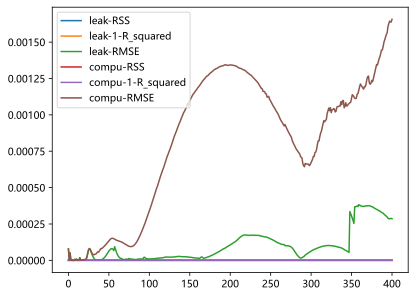

In [18]:
for item, level in zip([ leak_fit_accuracies, compu_fit_accuracies],["leak",'compu']):
    arr = np.array(item).reshape(-1,3)
    RSS = arr[:,0]
    R_squared = arr[:,1]
    RMSE = arr[:,2]
    plt.plot(tlist,RSS, label=f"{level}-RSS")
    plt.plot(tlist,1-R_squared, label=f"{level}-1-R_squared")
    plt.plot(tlist,RMSE, label=f"{level}-RMSE")
plt.legend()
# plt.ylim(-1e-5,1e-4)

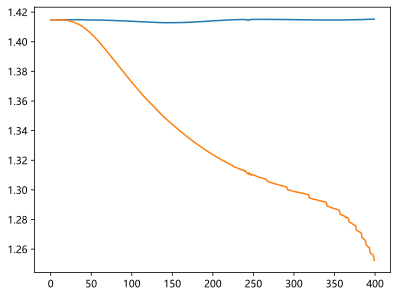

In [19]:
plt.plot(sigma_leak_list)
plt.plot(sigma_compu_list)

In [20]:
# contrast = np.abs(results[1].expect[0]-results[0].expect[0])
contrast = np.abs(np.array(mu_leak_list)-np.array(mu_compu_list))
contrast = np.array(contrast)[:last_t_idx+1]

alpha_arr_0 = np.sqrt(kappa)*( results[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)  )[:last_t_idx+1] 
alpha_arr_1 = np.sqrt(kappa)*( results[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1] 
diff_arr = np.abs(alpha_arr_0-alpha_arr_1)

weight = contrast
# weight[:] = 0
# weight = np.ones_like(contrast)#using a uniform weight can degrade the SNR

efficiency = 1

# weight_integral = np.trapz(weight**2,tlist[:last_t_idx+1])
# constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
# weight = weight/np.sqrt(weight_integral / constant_weight_integral)

weight_integral = np.trapz(weight,tlist[:last_t_idx+1])
constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
weight = weight/(weight_integral / constant_weight_integral)

integrated_contrast =  np.sqrt(kappa*efficiency)*scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0)

numerator = np.sqrt(kappa * efficiency) * scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0)


integrated_variance_leakage = kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_leak_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
integrated_variance_compu =kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_compu_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
integrated_sd = np.sqrt(integrated_variance_leakage + integrated_variance_compu)

denominator =np.sqrt(kappa *  tlist[:last_t_idx+1] / 2 * 2)
denominator[0]+= 1e-10 # avoid dividing by zero

snr = integrated_contrast / integrated_sd
SNR = numerator / denominator

 /tmp/ipykernel_4069/3766094933.py: 35

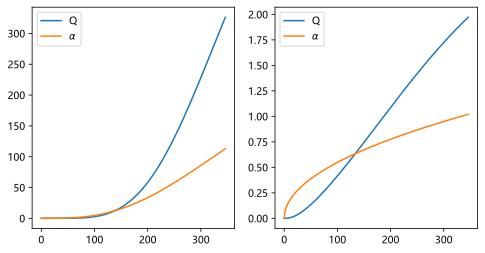

In [21]:
fig, axes = plt.subplots(1,2,figsize = (8,4))

axes[0].plot(scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0),label='Q')
axes[0].plot(scipy.integrate.cumulative_trapezoid(diff_arr, tlist[:last_t_idx+1],initial=0),label=r'$\alpha$')
axes[0].legend()
axes[1].plot(integrated_sd,label='Q')
axes[1].plot(np.sqrt(kappa *  tlist[:last_t_idx+1] / 2 * 2),label=r'$\alpha$')
axes[1].legend()


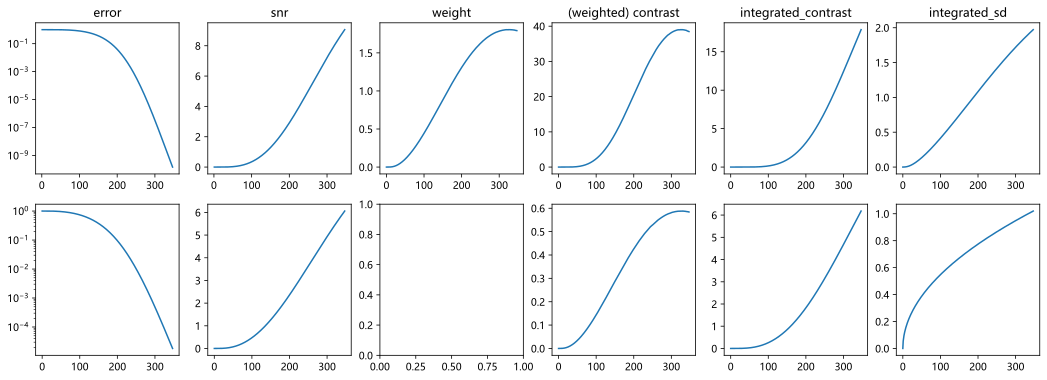

In [22]:
fig, axes = plt.subplots(2,6,figsize = (18,6))
axes[0,0].plot(tlist[:last_t_idx+1],erfc(snr/2) )
axes[0,0].set_title('error')
axes[0,0].set_yscale('log')
axes[1,0].plot(tlist[:last_t_idx+1],erfc(SNR/2))
axes[1,0].set_yscale('log')

axes[0,1].plot(tlist[:last_t_idx+1],snr)
axes[0,1].set_title('snr')
axes[1,1].plot(tlist[:last_t_idx+1], SNR)

axes[0,2].plot(tlist[:last_t_idx+1], weight)
axes[0,2].set_title('weight')
# axes[1,2].plot(tlist[:last_t_idx+1], SNR)

axes[0,3].plot(tlist[:last_t_idx+1], contrast * weight)
axes[0,3].set_title('(weighted) contrast')
axes[1,3].plot(tlist[:last_t_idx+1], diff_arr )

axes[0,4].plot(tlist[:last_t_idx+1],integrated_contrast )
axes[0,4].set_title('integrated_contrast')
axes[1,4].plot(tlist[:last_t_idx+1], numerator )

axes[0,5].plot(tlist[:last_t_idx+1], integrated_sd)
axes[0,5].set_title('integrated_sd')
axes[1,5].plot(tlist[:last_t_idx+1],denominator )


# calculate leakage

In [5]:

leakage_arr = np.zeros(shape=(3,len(tlist)))
for ql,result in zip([0,1,2],[results[0],results[1],results[2]]):
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = result.states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[ql,t_idx] = 1-qutip.expect(op, rho_qbt)

t loop: 100%|██████████| 400/400 [00:01<00:00, 348.00it/s]


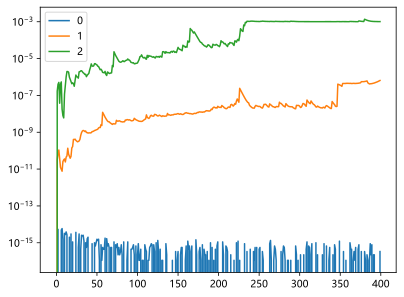

In [6]:
for ql in [0,1,2]:
    plt.plot(leakage_arr[ql],label=f'{ql}')
plt.legend()
plt.yscale('log')

# Plotting

# computational states

In [7]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


Processing: 100%|██████████| 400/400 [00:36<00:00, 10.88it/s]


Text(0.5, 1.0, 'infidelity')

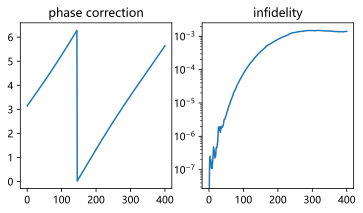

In [8]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(1,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 1,2) for result in results[1:]]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])
    

fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')


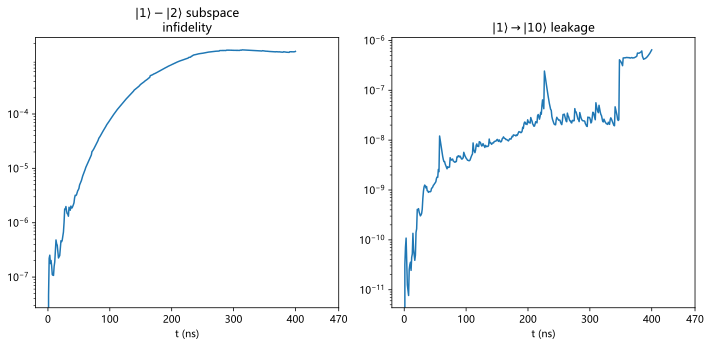

In [12]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

ax0 = axes[0]
ax0.set_title(r'''$|1\rangle-|2\rangle$ subspace
infidelity''')
ax0.plot(tlist,infidelity, color='#1f77b4')
ax0.set_yscale('log')
ax0.set_xticks([0,100,200,300,400,470])
# ax0.set_ylim(1e-6,5e-4)
ax0.set_yticks([1e-7,1e-6,1e-5,1e-4])
ax0.set_xlabel("t (ns)")


ax1 = axes[1]
ax1.plot(tlist,leakage_arr[1], color='#1f77b4')
ax1.set_title(rf'$|{1}\rangle\rightarrow |{10}\rangle$ leakage')
ax1.set_yscale('log')
ax1.set_xticks([0,100,200,300,400,470])
ax1.set_xlabel("t (ns)")


# plt.text(-0.25, 1.1, '(a)', transform=plt.subplot(gs[0,0]).transAxes, fontsize=14, va='top', color='black')
# plt.text(-0.25, 1.1, '(b)', transform=plt.subplot(gs[0,1]).transAxes, fontsize=14, va='top', color='black')
# plt.text(-0.25, 1.1, '(c)', transform=plt.subplot(gs[1,0]).transAxes, fontsize=14, va='top', color='black')
# plt.text(-0.25, 1.1, '(d)', transform=plt.subplot(gs[1,1]).transAxes, fontsize=14, va='top', color='black')

plt.tight_layout()
# fig.savefig('fig05_fidelity.pdf')